# Customer Churn @ Neto

## Objective

The basic pretence of this experient is to see if we can take a load of information about Neto's customers and train a machine learning modle

## Current data points



## Assumptions

### What is churn?

In the context of this experiement, churn is defined as when a customer leaves the Neto platform

### Defaulting missing values



## Caveats

In [ ]:
%reload_ext autoreload

In [36]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0

In [179]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
sys.path.append('../lib')
import utils
import preprocessing

In [181]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [182]:
print(len(df_raw), df_raw.shape)
df_processed = preprocessing.prepare_data(df_raw)
print(len(df_processed), df_processed.shape)

5889 (5889, 38)
Feature has NaN values: churn_concern_cases_total
Feature has NaN values: churn_concern_cases_open
Feature has NaN values: total_churn_concern_cases_age
Feature has NaN values: churn_concern_cases_avg_hours
5889 (5889, 99)


/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [183]:
df_filtered = df_processed[df_processed.licence_registration_Year >2015]
#df_filtered = df_processed
print(len(df_processed), df_processed.shape)

5889 (5889, 99)


In [184]:
#df_processed['cases_age_hours_total_log'] = df_processed['cases_age_hours_total_log'].isna().fillna(df_processed['cases_age_hours_total_log'].mean())
#df_processed[df_processed['cases_age_hours_total_log'].isna() == True]
#df_processed[df_processed.isna() == True]

In [185]:
print(len(df_filtered[df_filtered.nps_detractor == 1]),len(df_filtered[df_filtered.nps_passive == 1]),len(df_filtered[df_filtered.nps_promoter == 1]))


4167 61 74


In [186]:
len(df_filtered[df_filtered.churned == 1]), len(df_filtered[df_filtered.churned == 0])

(2276, 2125)

In [187]:
print(len(df_filtered), df_filtered.shape)

4401 (4401, 99)


In [188]:
df_trn, y_trn, nas = proc_df(df_filtered, 'churned')
print(len(df_trn), df_trn.shape)

4401 (4401, 102)


/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [189]:
df_trn.columns

Index(['username', 'team', 'vertical', 'salesperson', 'cases_total',
       'cases_open', 'cases_closed', 'cases_age_hours_average',
       'interactions_total', 'interactions_completed',
       ...
       'golive_Is_year_start', 'golive_Elapsed', 'days_active_log',
       'golive_days_log', 'cases_age_hours_total_log', 'annual_revenue_log',
       'churn_concern_cases_total_na', 'churn_concern_cases_open_na',
       'total_churn_concern_cases_age_na', 'churn_concern_cases_avg_hours_na'],
      dtype='object', length=102)

In [190]:
preprocessing.features_with_nan(df_trn)

In [191]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [192]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [193]:
len(df_filtered[df_filtered.churned == 1]), len(df_filtered[df_filtered.churned == 0]), len(y_train_res)

(2276, 2125, 4390)

In [ ]:
# Tuning hyperparameters

tune = True

if tune:
    # Create the hyperparameter grid
    param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
                  'min_samples_leaf': np.arange(1,5),
                  'n_estimators': np.arange(1,200),
                  'class_weight':[{0: w} for w in [1, 2, 3, 5]],
                  'bootstrap': [True, False],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [None, 1, 2, 3, 5]
                 }

    # Call GridSearchCV
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid)

    # Fit the model
    %time grid_search.fit(X_valid, y_valid)

    print(grid_search.best_params_, grid_search.best_score_)

/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [175]:
m = RandomForestClassifier(
    n_estimators=2000,
    min_samples_leaf=3, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train_res, y_train_res)
#m.fit(X_train, y_train)

y_pred = m.predict(X_valid)
print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "churn_model.pkl"
joblib.dump(m, joblib_file)

0.7027027027027027 0.32098765432098764 0.4406779661016949 0.868 0.37742897030524847 0.132
None
[[408  11]
 [ 55  26]]


['churn_model.pkl']

In [148]:
fi = rf_feat_importance(m, X_valid); fi[:10]

,cols,imp
9,interactions_completed,0.118894
52,plan_PLAN-S-17Q2,0.103203
6,cases_closed,0.094054
8,interactions_total,0.092669
5,cases_open,0.087019
53,plan_PLAN-S-19Q1,0.071505
4,cases_total,0.068247
93,golive_Elapsed,0.053336
86,golive_Dayofyear,0.037051
81,golive_Year,0.035557


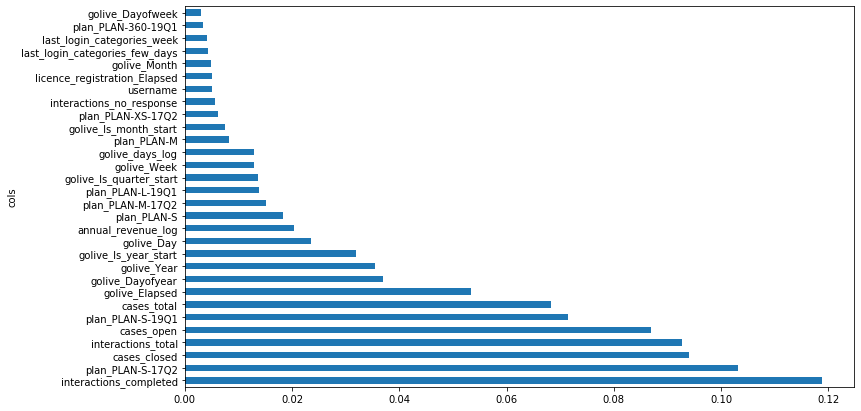

In [149]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [150]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [151]:
m = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=2, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='entropy',
    class_weight={0: 4, 1: 1}
    )

m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 4, 1: 1},
                       criterion='entropy', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

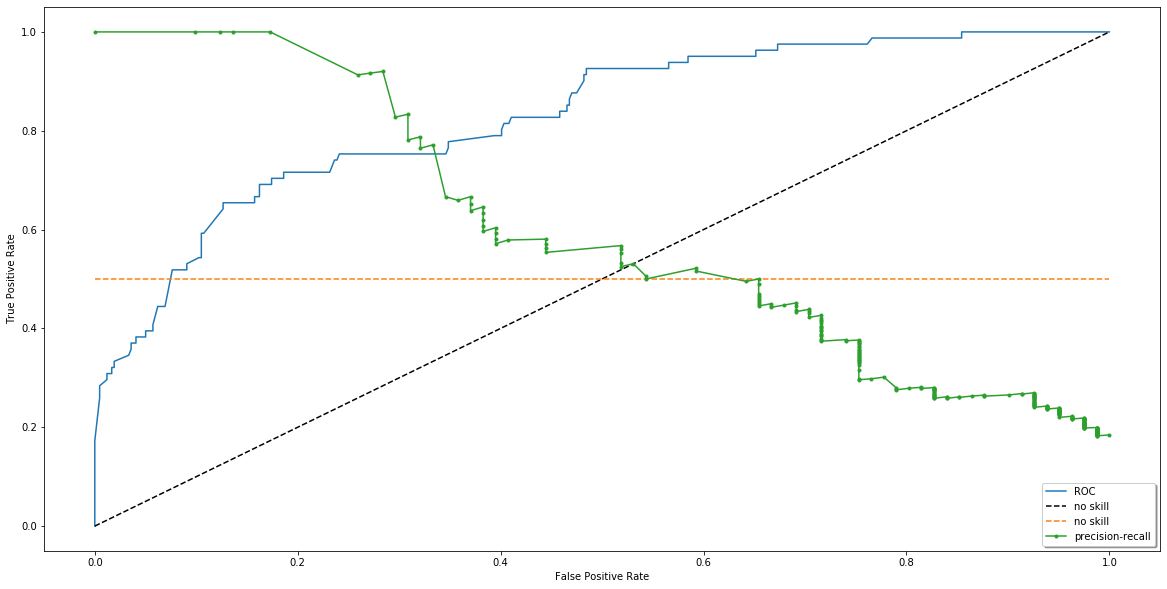

auc=0.603 ap=0.599


In [152]:
utils.plot_roc_pr(m, X_valid, y_valid)

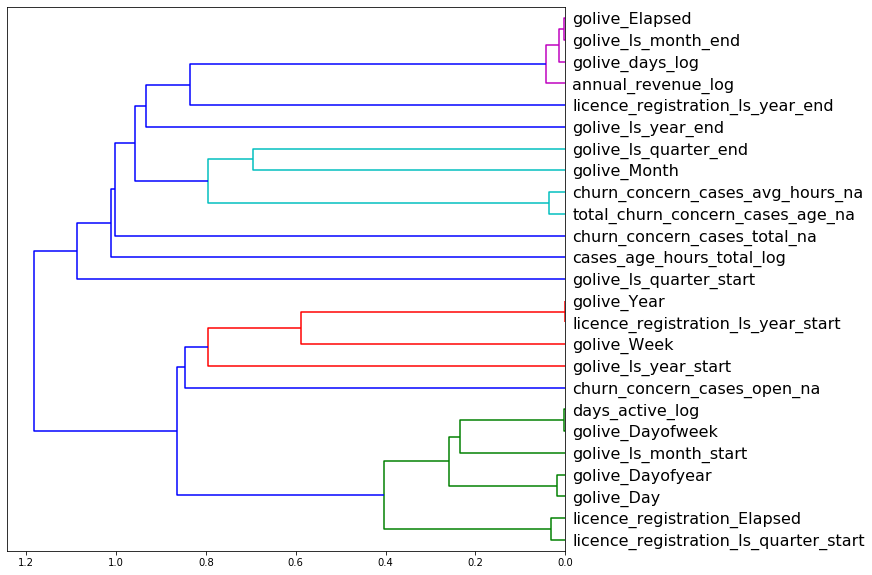

In [153]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [154]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
0.9783989834815756 0.6730769230769231 0.797514241325738 0.8270676691729323 0.6553857488398201 0.17293233082706766
interactions_completed None
0.968421052631579 0.5629370629370629 0.7119955776672194 0.7695709862892526 0.5413969864857868 0.23042901371074745
plan_PLAN-S-17Q2 None
0.9802631578947368 0.6512237762237763 0.7825630252100841 0.8168951791242813 0.6352179836512262 0.18310482087571872
cases_closed None
0.9812834224598931 0.6416083916083916 0.7758985200845665 0.8124723573639983 0.6264539890304973 0.18752764263600177
interactions_total None
0.9798927613941019 0.638986013986014 0.7735449735449736 0.810703228659885 0.6229379039152259 0.189296771340115
cases_open None
0.9859154929577465 0.6118881118881119 0.7551240560949299 0.799203892083149 0.6001836867758764 0.20079610791685096
plan_PLAN-S-19Q1 None
0.9799196787148594 0.6398601398601399 0.7741935483870969 0.8111455108359134 0.6238149325031221 0.18885448916408668